In [1]:
using Distributed
procs_to_use = 5
if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end
;

In [2]:
@everywhere using QuantumStates, OpticalBlochEquations, DifferentialEquations, UnitsToValue, StructArrays, StaticArrays, Parameters

@everywhere import Distributions: Normal, Geometric, Exponential
@everywhere using ProgressMeter, Plots
;

In [3]:
@everywhere include("helper_functions.jl")
@everywhere include("define_molecular_structure.jl")
@everywhere include("define_sim_params.jl")
@everywhere include("define_prob.jl")
@everywhere include("compute_size_temperature.jl")
;

      From worker 3:	(2.28545530795343, 1.142727653976715)


(2.28545530795343, 1.142727653976715)

      From worker 4:	(2.28545530795343, 1.142727653976715)
      From worker 5:	(2.28545530795343, 1.142727653976715)
      From worker 2:	(2.28545530795343, 1.142727653976715)


In [4]:
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

prob_func!(prob)
@time sol = DifferentialEquations.solve(prob, progress=true, progress_steps=300000, save_everystep=true)
# @time sol = DifferentialEquations.solve(prob, save_everystep=false, saveat=[])
;

ODE   0%|█                                              |  ETA: N/A
ODE  24%|████████████                                   |  ETA: 0:00:12
ODE  48%|███████████████████████                        |  ETA: 0:00:08
ODE  73%|███████████████████████████████████            |  ETA: 0:00:04
ODE  96%|██████████████████████████████████████████████ |  ETA: 0:00:00


 27.419191 seconds (317.67 M allocations: 8.889 GiB, 17.13% gc time, 54.92% compilation time)


ODE 100%|███████████████████████████████████████████████| Time: 0:00:13


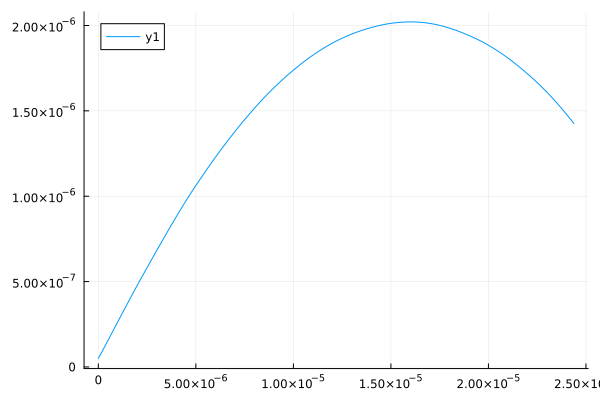

In [5]:
xs = z.(sol.u)

plot(sol.t[1:10000] ./ Γ,xs[1:10000])

In [6]:
using FFTW

function primary_frequency(data, sample_rate)
    # Perform FFT
    fft_result = fft(data)
    
    # Compute magnitudes of FFT coefficients
    magnitudes = abs.(fft_result)

    # Find the index of the maximum magnitude (excluding the zero frequency component)
    max_index = argmax(magnitudes[15:1000]) + 1

    # Calculate the frequency corresponding to the primary component
    freq = (max_index - 1) * sample_rate / length(data)

    return freq
end

# Example usage:
sample_rate = (length(sol.t) - 1) * Γ / (sol.t[end] - sol.t[1])
primary_frequency(xs, sample_rate) / 1e3 |> display
# should be 191 radial and 33 axial

12.333323404216495

In [7]:
prob.p.add_spontaneous_decay_kick = true
n_trajectories = 50 #1
@time sols = distributed_solve(n_trajectories, prob, prob_func!, scan_nothing, [0])
;

4

Progress: 100%|█████████████████████████████████████████| Time: 0:09:19


569.888813 seconds (6.70 M allocations: 341.390 MiB, 0.03% gc time, 1 lock conflict, 0.40% compilation time)


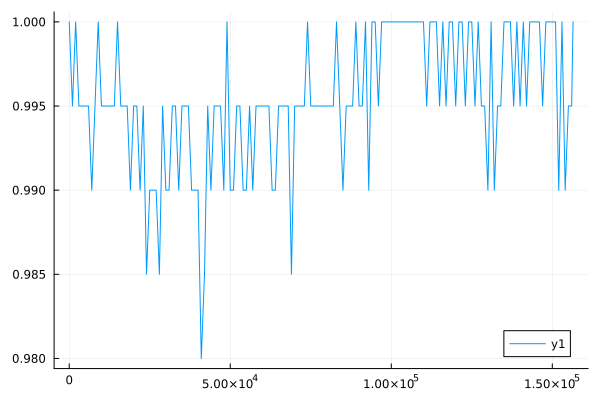

In [8]:
xs_dfsha, ys_dfsha = survival_rate_curve(sols[1])
plot(xs_dfsha, ys_dfsha)

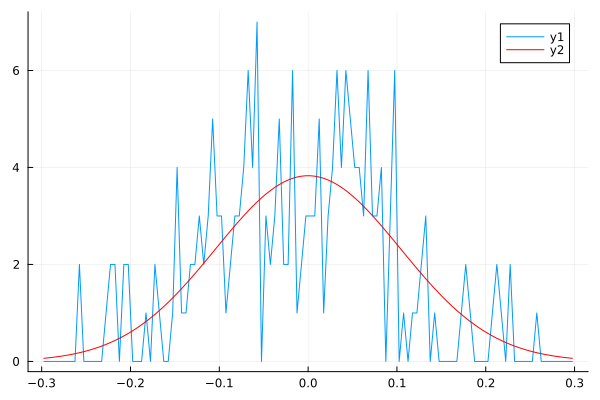

In [9]:
i = 1

vxs = [vx.(sol.u)[i] for sol ∈ sols[1] if survived(sol,i)]
vys = [vy.(sol.u)[i] for sol ∈ sols[1] if survived(sol,i)]
vzs = [vz.(sol.u)[i] for sol ∈ sols[1] if survived(sol,i)]

# vxs = [vx.(sol.u)[end] for sol ∈ sols[1]]
# vys = [vy.(sol.u)[end] for sol ∈ sols[1]]
# vzs = [vz.(sol.u)[end] for sol ∈ sols[1]]

vs = sqrt.(vxs.^2 .+ vys.^2 .+ vzs.^2)

hist_data = fit(Histogram, vxs, -0.3:0.005:0.3)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(maxwell_boltzmann_1D, v, fv, [1, 0.1e-6], autodiff=:forward)
A, temp = v_fit.param

plot(v, fv)
plot!(v, maxwell_boltzmann_1D(v, v_fit.param), color=:red)

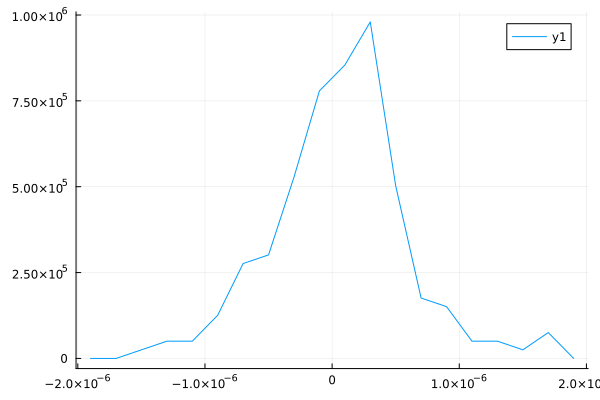

In [10]:
i = 60

xs = [x.(sol.u)[i] for sol ∈ sols[1]]
ys = [y.(sol.u)[i] for sol ∈ sols[1]]
zs = [z.(sol.u)[i] for sol ∈ sols[1]]

r = sqrt.(xs.^2 .+ ys.^2 .+ zs.^2)

hist_data = fit(Histogram, zs, -20e-7:20e-8:20e-7)
hist_data.isdensity = true
xx = collect(hist_data.edges[1])
dx = xx[2]-xx[1]
xx = xx[1:end-1] .+ dx/2
fx = hist_data.weights ./ (sum(hist_data.weights) * dx)

plot(xx, fx)

18.597316871050122

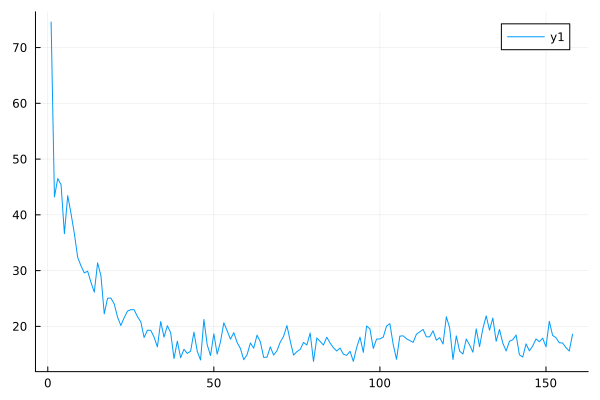

In [11]:
Ts = T_vs_time(sols[1])
display(Ts[end] .* 1e6)
plot(Ts .* 1e6)

In [12]:
sols[1][10].prob.p.n_scatters / 3e-3 |> display
sols[1][10].prob.p.n_scatters |> display

# should be 200k

264333.3333333333

793.0

# Include diffusion

### "Actual With Diffusion"

In [ ]:
n_trajectories1 = 50
n_trajectories2 = 50
# n_times = 100
n_times = 10
# n_trajectories_diffusion = 10000 # # of particles ran for the diffusion.
# diffusion_t_end = 20e-6 # first 10us: reach equilibrium.
# diffusion_τ_total = 20e-6 # and then averaging through 10us evolution.

n_trajectories_diffusion = 50000 # # of particles ran for the diffusion.
diffusion_t_end = 0e-6 # first 10us: reach equilibrium.
diffusion_τ_total = 6e-6 # and then averaging through 10us evolution.
# n_trajectories_diffusion = 500 # # of particles ran for the diffusion.
# diffusion_t_end = 5e-6 # first 10us: reach equilibrium.
# diffusion_τ_total = 1e-3 # and then averaging through 10us evolution.
# n_trajectories_diffusion = 5000 # # of particles ran for the diffusion.
# diffusion_t_end = 10e-6 # first 10us: reach equilibrium.
# diffusion_τ_total = 10e-6 # and then averaging through 10us evolution.
;

In [8]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob, prob_func!, prob, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
) # this is really slow, but this is rigorous.
# (sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
#     compute_trajectories_with_diffusion(
#     prob, prob_func!, prob_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
# )
;

4

Progress: 100%|█████████████████████████████████████████| Time: 0:07:50
Progress: 100%|█████████████████████████████████████████| Time: 1:46:00


4

Progress: 100%|█████████████████████████████████████████| Time: 0:25:33


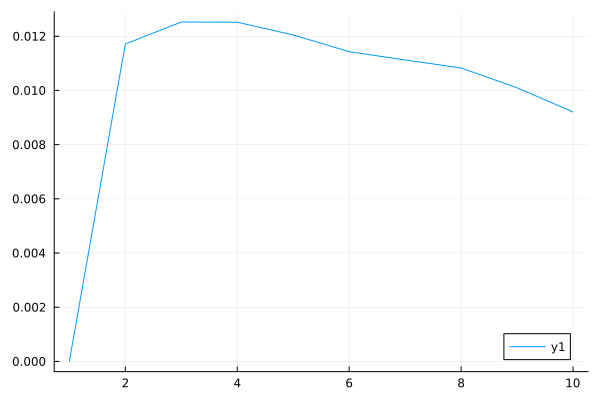

In [9]:
plot(diffusion_over_time)

In [10]:
diffusion, diffusion_error

(0.00920502492488029, 0.0007356226471225202)

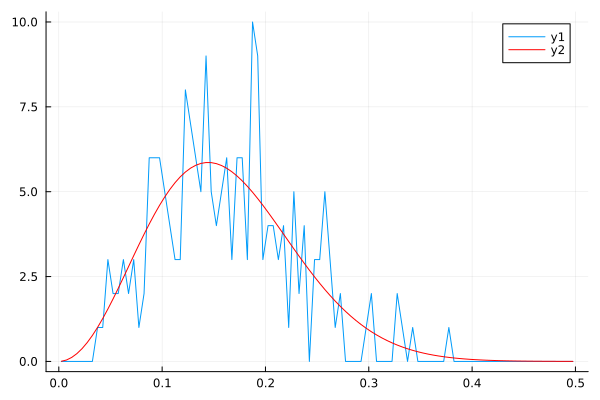

In [11]:
i = 1
vxs = [vx(sol.u[i]) for sol ∈ sols_with_diffusion if survived(sol,i)]
vys = [vy(sol.u[i]) for sol ∈ sols_with_diffusion if survived(sol,i)]
vzs = [vz(sol.u[i]) for sol ∈ sols_with_diffusion if survived(sol,i)]
vs = sqrt.(vxs.^2 .+ vys.^2 .+ vzs.^2)

hist_data = fit(Histogram, vs, 0:0.005:0.5)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(maxwell_boltzmann, v, fv, [1, 5e-6], autodiff=:forward)
A, temp = v_fit.param

plot(v, fv)
plot!(v, maxwell_boltzmann(v, v_fit.param), color=:red)

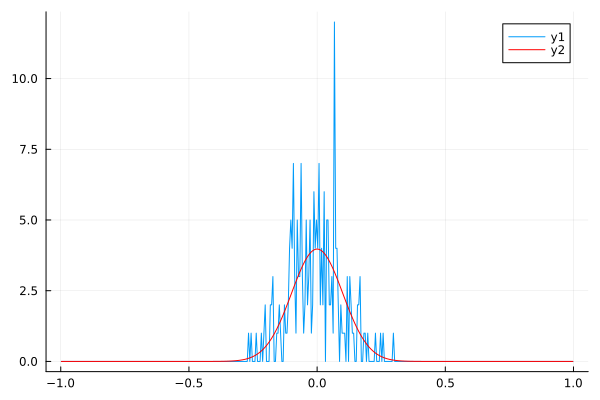

In [12]:
i = 1
vxs = [vx(sol.u[i]) for sol ∈ sols_with_diffusion if survived(sol,i)]
vys = [vy(sol.u[i]) for sol ∈ sols_with_diffusion if survived(sol,i)]
vzs = [vz(sol.u[i]) for sol ∈ sols_with_diffusion if survived(sol,i)]
vs = sqrt.(vxs.^2 .+ vys.^2 .+ vzs.^2)

hist_data = fit(Histogram, vxs, -1:0.005:1)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(maxwell_boltzmann_1D, v, fv, [1, 0.1e-6], autodiff=:forward)
A, temp = v_fit.param

plot(v, fv)
plot!(v, maxwell_boltzmann_1D(v, v_fit.param), color=:red)

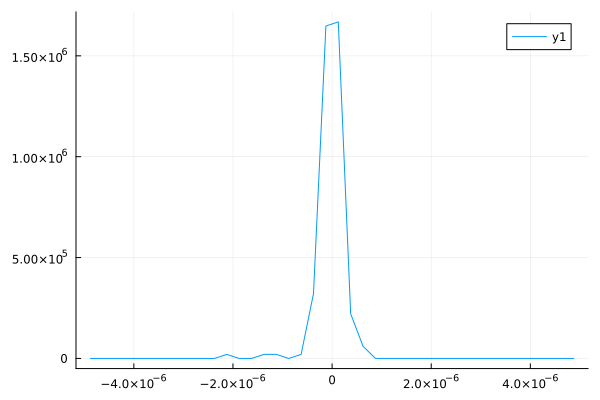

In [13]:
i = 20

xs = [x.(sol.u)[i] for sol ∈ sols_with_diffusion]
ys = [y.(sol.u)[i] for sol ∈ sols_with_diffusion]
zs = [z.(sol.u)[i] for sol ∈ sols_with_diffusion]

r = sqrt.(xs.^2 .+ ys.^2 .+ zs.^2)

hist_data = fit(Histogram, xs, -50e-7:25e-8:50e-7)
hist_data.isdensity = true
xx = collect(hist_data.edges[1])
dx = xx[2]-xx[1]
xx = xx[1:end-1] .+ dx/2
fx = hist_data.weights ./ (sum(hist_data.weights) * dx)

plot(xx, fx)

32.021515408378676

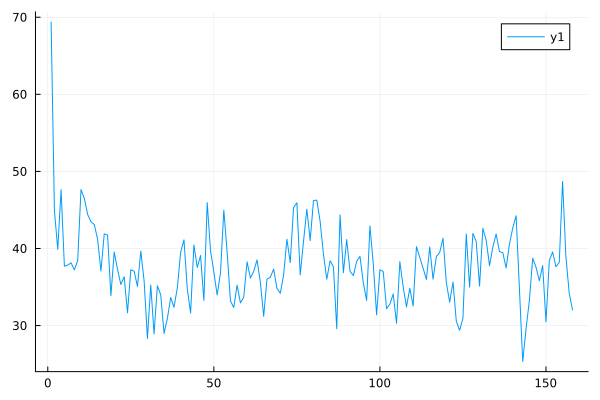

In [14]:
Ts = T_vs_time(sols_no_diffusion)
display(Ts[end] .* 1e6)
plot(Ts .* 1e6)

69.38904994261445

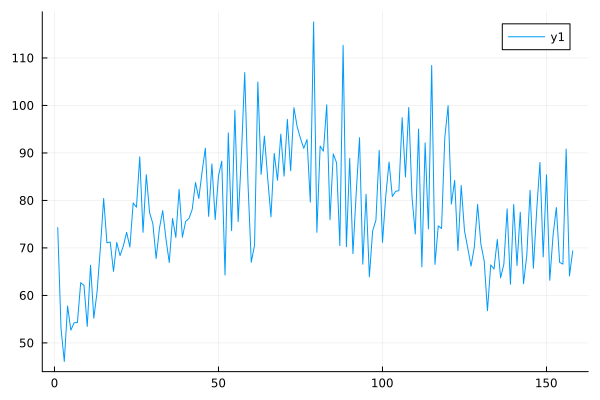

In [15]:
Ts = T_vs_time(sols_with_diffusion)
display(Ts[end] .* 1e6)
plot(Ts .* 1e6)
# 40MHz: 65uK
# 32MHz: 59uK
# 32MHz, twice: 60uK
# 40MHz, twice: 85uK
# 24MHz, twice: 46uK
# 16MHz, twice: 50uK
# 5MHz, twice: (150uK)

# 16MHz at +0.1F2: 48uK
# 16MHz at +1.0F2: 67uK

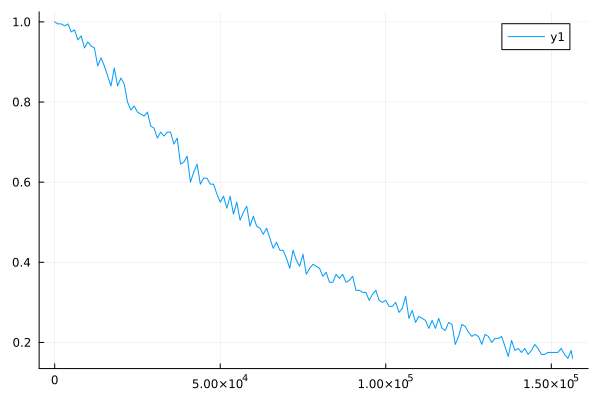

In [18]:
xs_dfshb, ys_dfshb = survival_rate_curve(sols_with_diffusion)
plot(xs_dfshb, ys_dfshb)
# 40MHz: 0.6 at 2ms
# 32MHz: 0.6 at 2ms
# 40MHz, twice: 0.6 at 2ms
# 32MHz, twice: 0.75 at 2ms
# 24MHz, twice: 0.9 at 2ms
# 16MHz, twice: 0.9 at 2ms
# 5MHz, twice: 0.1 at 2ms

# 16MHz at +0.1F2: 0.95 at 2ms
# 16MHz at +1.0F2: 0.72 at 2ms

In [23]:
sols_with_diffusion[10].prob.p.n_scatters / 3e-3 |> display
# should be 200k
# 40MHz: 353k
# 32MHz: 610k
# 40MHz, twice: 166k
# 32MHz, twice: 198k
# 24MHz, twice: 251k
# 16MHz, twice: 333k
# 5MHz, twice: 439k

# 16MHz at +0.1F2: 385k
# 16MHz at +1.0F2: 431k

# n_scatters / log(p)

59000.0

In [24]:
using Serialization
using Printf

# Assuming all variables are defined
filename = @sprintf("results/cooling_sim_d%.2fd%.2fd%.2fb%.2fs%.2fs%.2ft%.2f.jl",
                    detuning,
                    δ1,
                    δ2,
                    beam_radius / 1e-3,
                    s1 / total_sat,
                    s2 / total_sat,
                    Temperature_initial / 1e-6)

serialize(filename, sols_with_diffusion)


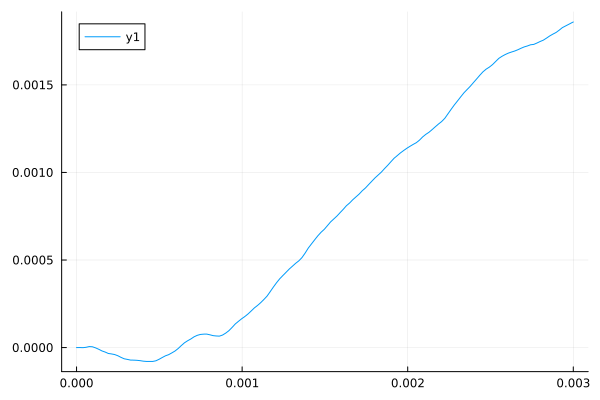

In [25]:
xs = x.(sols_with_diffusion[5].u)

plot(sols_with_diffusion[5].t ./ Γ,xs)